# <center>Homework 4</center>
### <center>_Tanner S Eastmond_</center>

## Surviving the Titanic

What differentiated people who survived or did not survive the Titanic disaster? This has been on the question of many amateur and even professional historians. In connection with the Kaggle competition [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic), we will explore what characteristics differentiated whether or not a person on the Titanic survived or not.

In [53]:
# Import the packages we need.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.linear_model import SGDRegressor, LogisticRegression, ElasticNetCV, LassoCV
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

## Data Description and Cleaning

In [2]:
# Read in the data and get a first look.
df = pd.read_csv('train_titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


First we will deal with missing data. We will see what is missing first and see if it is missing at random.

In [3]:
# Check what is missing.
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
# See if age is missing at random.
df.Survived.loc[df.Age.isnull()].value_counts()

0    125
1     52
Name: Survived, dtype: int64

So Cabin is missing if the person did not have a cabin, but age is a problem. More than twice as many people missing age did not survive. We will imput the values using a hot-deck method, then include a feature for the person missing age.

In [5]:
# Fill embarked with random values.
df.loc[(df.Embarked.isnull()), 'Embarked'] = df.apply(lambda x: np.random.choice(['S', 'C', 'Q']), axis=1)

In [6]:
# Generate a variable for missing age.
df['age_missing'] = df.Age.isnull()

# Impute missing variables.
df.loc[(df.Age.isnull()), 'Age'] = df.apply(lambda x: np.random.choice(df.Age.dropna()), axis=1)

Now let's learn a little bit about our "Survived" variable.

In [7]:
# See how many are in each class.
df.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [8]:
# Print out variables by class.
pd.pivot_table(df, values=['Age', 'SibSp', 'Parch', 'Fare'], index=['Sex', 'Pclass'], columns=['Survived']).round(decimals=2)

Age           Fare         Parch       SibSp      
Survived           0      1       0       1     0     1     0     1
Sex    Pclass                                                      
female 1       25.67  33.59  110.60  105.98  1.33  0.43  0.67  0.55
       2       36.00  27.95   18.25   22.29  0.17  0.64  0.50  0.49
       3       25.03  22.70   19.77   12.46  1.10  0.50  1.29  0.50
male   1       40.84  35.40   62.89   74.64  0.26  0.31  0.27  0.38
       2       33.33  19.37   19.49   21.10  0.14  0.65  0.31  0.53
       3       27.40  24.09   12.20   15.58  0.21  0.30  0.52  0.34

Interesting. In every case with age, younger people survived, except for first-class female passengers, of whom older women generally survived. Fare doesn't necessarily show a pattern for women, but for men, those who survived paid more on average for tickets. Also we do not necessarily observe a strong pattern for number of parents/children or siblings/spouses using this approach.

### _Categorical Variables_

Now we need to examine our categorical variables with the survived variable.

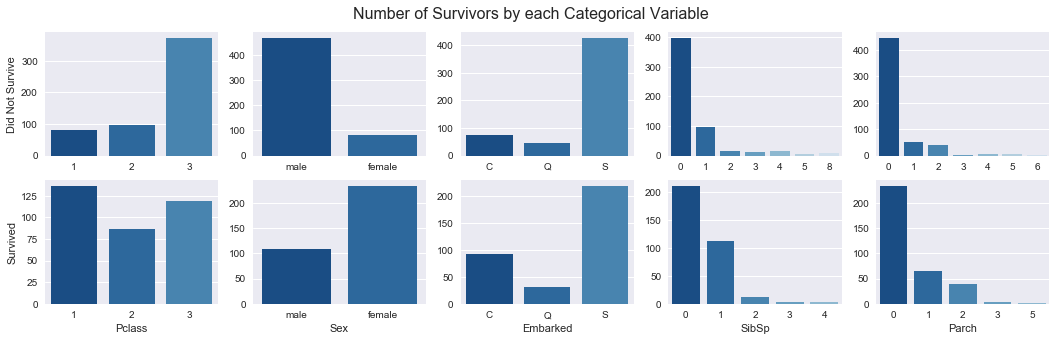

In [9]:
# Make a count plot for each.
# Initialize the plot.
fig, axes = plt.subplots(2, 5, figsize=(18,5))

# Title the plot.
fig.suptitle('Number of Survivors by each Categorical Variable', fontsize=16, y=.95)

# Make the plots.
sns.countplot(x='Pclass', data=df.loc[df.Survived == 0], order=[1, 2, 3], palette=sns.color_palette("Blues_r", 8), ax=axes.flatten()[0])
sns.countplot(x='Sex', data=df.loc[df.Survived == 0], order=['male', 'female'], palette=sns.color_palette("Blues_r", 8), ax=axes.flatten()[1])
sns.countplot(x='Embarked', data=df.loc[df.Survived == 0], order=['C', 'Q', 'S'], palette=sns.color_palette("Blues_r", 8), ax=axes.flatten()[2])
sns.countplot(x='SibSp', data=df.loc[df.Survived == 0], palette=sns.color_palette("Blues_r", 8), ax=axes.flatten()[3])
sns.countplot(x='Parch', data=df.loc[df.Survived == 0], palette=sns.color_palette("Blues_r", 8), ax=axes.flatten()[4])

sns.countplot(x='Pclass', data=df.loc[df.Survived == 1], order=[1, 2, 3], palette=sns.color_palette("Blues_r", 8), ax=axes.flatten()[5])
sns.countplot(x='Sex', data=df.loc[df.Survived == 1], order=['male', 'female'], palette=sns.color_palette("Blues_r", 8), ax=axes.flatten()[6])
sns.countplot(x='Embarked', data=df.loc[df.Survived == 1], order=['C', 'Q', 'S'], palette=sns.color_palette("Blues_r", 8), ax=axes.flatten()[7])
sns.countplot(x='SibSp', data=df.loc[df.Survived == 1], palette=sns.color_palette("Blues_r", 8), ax=axes.flatten()[8])
sns.countplot(x='Parch', data=df.loc[df.Survived == 1], palette=sns.color_palette("Blues_r", 8), ax=axes.flatten()[9])

# Share the x and y axis label.
for x in range(5):
    axes.flatten()[x].set_xlabel('')
    
for x in [1, 2, 3, 4, 6, 7, 8, 9]:
    axes.flatten()[x].set_ylabel('')

axes.flatten()[0].set_ylabel('Did Not Survive')
axes.flatten()[5].set_ylabel('Survived')

Keep track of the scale well, but we can see that more than twice as many females survived than didn't or than males, and most males did not survive. Also, a higher proportion of first class passengers survived than the other classes. The pattern is not super clear for where passengers embarked. It also looks like a larger percentage of people who did not survive had no family with them.

### _Continuous Variables_

Let's take a look at the continuous variables.

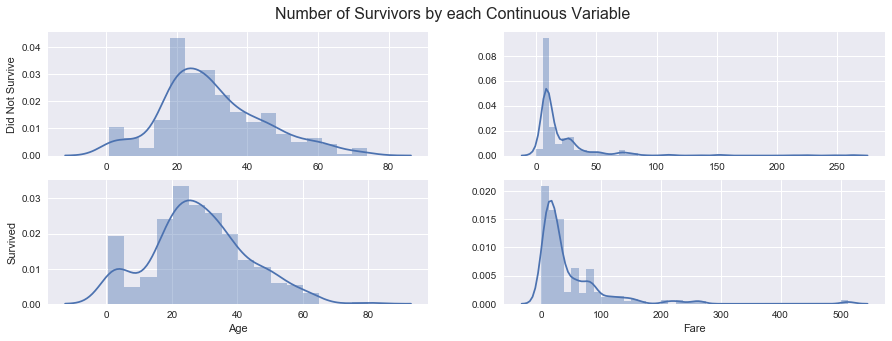

In [10]:
# Make a histogram for each.
# Initialize the plot.
fig, axes = plt.subplots(2, 2, figsize=(15,5))

# Title the plot.
fig.suptitle('Number of Survivors by each Continuous Variable', fontsize=16, y=.95)

# Define the plots.
sns.distplot(df['Age'].loc[df.Survived == 0].dropna(), ax=axes.flatten()[0])
sns.distplot(df['Fare'].loc[df.Survived == 0].dropna(), ax=axes.flatten()[1])

sns.distplot(df['Age'].loc[df.Survived == 1].dropna(), ax=axes.flatten()[2])
sns.distplot(df['Fare'].loc[df.Survived == 1].dropna(), ax=axes.flatten()[3])

# Share the x and y axis label.
for x in range(2):
    axes.flatten()[x].set_xlabel('')
    
for x in [1, 3]:
    axes.flatten()[x].set_ylabel('')

axes.flatten()[0].set_ylabel('Did Not Survive')
axes.flatten()[2].set_ylabel('Survived')

The distributions are not vastly different, though a lot more people had higher fares that survived than those who didn't, and more children survived relative to other age groups.

### _New Features_

Well, we have a feel for the original features in the data. Let's engineer some other features now. First, let's start with family. We are going to feed in the family features as continuous variables, but let's make another feature for total family size, and one for whether the person has no family on board or not.

We will also make a few more age features. We will make a variable for young children (5 and under), and elderly (65 and over). Fare will also likely be useful as a category, so we will use quintiles.

We also can get some information about cabin and where the person was on the ship, so let's construct those variables. We will make variables for whether someone had a cabin or not and what floor they were on.

In [11]:
def Clean(df):
    # Make a total family variable.
    df['total_fam'] = df['SibSp'] + df['Parch']
    
    # Make a variable for being alone.
    df['no_fam'] = 0
    df.loc[(df['total_fam'] == 0), 'no_fam'] = 1
    
    # Make a young child feature.
    df['young_child'] = 0
    df.loc[(df['Age'] <= 5), 'young_child'] = 1
    
    # Make an elderly person feature.
    df['elderly'] = 0
    df.loc[(df['Age'] >= 65), 'elderly'] = 1
    
    # Get the quartiles for fare.
    df['fare_q'] = pd.qcut(df.Fare, 5, labels=[0, 1, 2, 3, 4])
    
    # Make a variable for had a cabin.
    df['had_cabin'] = df.Cabin.notnull().astype(int)
    
    # Get the floor.
    df['floor'] = df.Cabin.str.extract('([A-Z]+)', expand=False)
    df['floor'] = df.floor.fillna('None')

In [12]:
# Run the function.
Clean(df)

Now we need to make the dummy variables for our data.

In [13]:
# Get the dummy variables.
df['Pclass'] = df['Pclass'].astype(object)
df['SibSp'] = df['SibSp'].astype(object)
df['Parch'] = df['Parch'].astype(object)
df1 = pd.get_dummies(df[['Pclass', 'Sex', 'Embarked', 'fare_q', 'floor', 'SibSp', 'Parch']])

# Join with the original data.
full = df.join(df1)

## Model


We will try a few different models, then use the best to submit to Kaggle.

First we will split the data into training and test sets.

In [14]:
# Mark the target variable and get the full data.
target = full.Survived
train = full[['Age', 'SibSp', 'Parch', 'Fare', 'age_missing', 'total_fam', 'no_fam', 'young_child', 'elderly', 'had_cabin',
             'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
             'fare_q_0', 'fare_q_1', 'fare_q_2', 'fare_q_3', 'fare_q_4', 'floor_A', 'floor_B', 'floor_C', 'floor_D',
             'floor_E', 'floor_F', 'floor_G', 'floor_None', 'floor_T', 'SibSp_0', 'SibSp_1', 'SibSp_2', 'SibSp_3',
             'SibSp_4', 'SibSp_5', 'SibSp_8', 'Parch_0', 'Parch_1', 'Parch_2', 'Parch_3',
             'Parch_4', 'Parch_5', 'Parch_6']]

# Make a train/test split.
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.33, random_state=42)

The first model we will try is the K-Nearest Neighbor algorithm.

In [47]:
# Run the K nearest neighbor algorithm.
param_dist = {"n_neighbors": [1, 3, 5, 7, 9, 11], "weights": ['uniform', 'distance'], 'p': [1, 2, 3]}

neighbor = KNeighborsClassifier()
gridsearch = GridSearchCV(neighbor, param_dist, scoring='f1')
gridsearch.fit(X_train, y_train)

# Get the predictions.
train_predictions = gridsearch.predict(X_train)
test_predictions = gridsearch.predict(X_test)

# Print the results.
print('Best Parameters:', gridsearch.best_params_)
print("Test Classification Report:")
print(classification_report(y_test, test_predictions))
print("Train Accuracy:", accuracy_score(y_train, train_predictions))
print("Test Accuracy:", accuracy_score(y_test, test_predictions))

Best Parameters: {'n_neighbors': 5, 'weights': 'distance', 'p': 1}
Test Classification Report:
             precision    recall  f1-score   support

          0       0.74      0.82      0.78       175
          1       0.69      0.57      0.63       120

avg / total       0.72      0.72      0.72       295

Train Accuracy: 0.989932885906
Test Accuracy: 0.722033898305


The recall is pretty bad, and we appear to be overfitting the data pretty badly. We will move on and try a Decision Tree.

In [48]:
# Run a Decision Tree with cross validated parameters.
param_dist = {'max_depth' : [1, 3, 5, 10], 'class_weight' : ['balanced', None]}

tree = DecisionTreeClassifier()
n_iter_search = 8
random_search = RandomizedSearchCV(tree, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=3, scoring='accuracy')
random_search.fit(X_train, y_train)

# Get the predictions.
train_predictions = random_search.predict(X_train)
test_predictions = random_search.predict(X_test)

# Print the results.
print('Best Parameters:', random_search.best_params_)
print("Test Classification Report:")
print(classification_report(y_test, test_predictions))
print('Train Accuracy:', accuracy_score(y_train, train_predictions))
print('Test Accuracy:', accuracy_score(y_test, test_predictions))

Best Parameters: {'class_weight': None, 'max_depth': 5}
Test Classification Report:
             precision    recall  f1-score   support

          0       0.82      0.85      0.84       175
          1       0.77      0.73      0.75       120

avg / total       0.80      0.80      0.80       295

Train Accuracy: 0.869127516779
Test Accuracy: 0.803389830508


Let's try an SVM model.

In [21]:
# Run the SVM model.
svc_model = SVC(C=0.5, kernel='rbf')
svc_model.fit(X_train, y_train)

# Get the predictions.
train_predictions = svc_model.predict(X_train)
test_predictions = svc_model.predict(X_test)

# Print the results.
print("Test Classification Report:")
print(classification_report(y_test, test_predictions))
print("Train Accuracy:", accuracy_score(y_train, train_predictions))
print("Test Accuracy:", accuracy_score(y_test, test_predictions))

Test Classification Report:
             precision    recall  f1-score   support

          0       0.67      0.94      0.78       175
          1       0.78      0.33      0.47       120

avg / total       0.72      0.69      0.65       295

Train Accuracy: 0.776845637584
Test Accuracy: 0.691525423729


Next we will try the Random Forest Model.

In [50]:
# Run a Random Forest model with cross validated parameters.
param_dist = {'n_estimators' : [1000, 2500, 5000], 'max_depth' : [1, 3, 5, 10], 'class_weight' : ['balanced', None]}

rand_forest = RandomForestClassifier()
n_iter_search = 8
random_search = RandomizedSearchCV(rand_forest, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=3, scoring='accuracy')
random_search.fit(X_train, y_train)

# Get the predictions.
train_predictions = random_search.predict(X_train)
test_predictions = random_search.predict(X_test)

# Print the results.
print('Best Parameters:', random_search.best_params_)
print("Test Classification Report:")
print(classification_report(y_test, test_predictions))
print('Train Accuracy:', accuracy_score(y_train, train_predictions))
print('Test Accuracy:', accuracy_score(y_test, test_predictions))

Best Parameters: {'class_weight': None, 'n_estimators': 1000, 'max_depth': 10}
Test Classification Report:
             precision    recall  f1-score   support

          0       0.80      0.86      0.83       175
          1       0.78      0.69      0.73       120

avg / total       0.79      0.79      0.79       295

Train Accuracy: 0.944630872483
Test Accuracy: 0.793220338983


The last model we will try Gradient Boosting.

In [51]:
# Run a Gradient Boosting model with cross validated parameters.
param_dist = {'n_estimators' : [1000, 2500, 5000], 'max_depth' : [1, 3, 5, 10]}

gradient_boosting = GradientBoostingClassifier()
n_iter_search = 8
random_search = RandomizedSearchCV(gradient_boosting, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=3, scoring='accuracy')
random_search.fit(X_train, y_train)

# Get the predictions.
train_predictions = random_search.predict(X_train)
test_predictions = random_search.predict(X_test)

# Print the results.
print('Best Parameters:', random_search.best_params_)
print("Test Classification Report:")
print(classification_report(y_test, test_predictions))
print('Train Accuracy:', accuracy_score(y_train, train_predictions))
print('Test Accuracy:', accuracy_score(y_test, test_predictions))

Best Parameters: {'n_estimators': 1000, 'max_depth': 1}
Test Classification Report:
             precision    recall  f1-score   support

          0       0.83      0.86      0.85       175
          1       0.79      0.75      0.77       120

avg / total       0.82      0.82      0.82       295

Train Accuracy: 0.860738255034
Test Accuracy: 0.816949152542


That was pretty good! The test accuracy was quite a bit better than the other models.

The last thing we will try is stacking each of the models to see if we can improve our predictions.

In [61]:
# Stack a few models.
neighbor = KNeighborsClassifier(n_neighbors=5, weights='distance', p=1)
tree = DecisionTreeClassifier(class_weight=None, max_depth=5)
svc_model = SVC(C=0.5, kernel='rbf')
rand_forest = RandomForestClassifier(class_weight=None, n_estimators=1000, max_depth=10)
gradient_boosting = GradientBoostingClassifier(n_estimators=1000, max_depth=1)

eclf = VotingClassifier(estimators=[('knn', neighbor), ('dt', tree), ('svc', svc_model), ('rf', rand_forest), 
                                    ('gb', gradient_boosting)], voting='hard')
eclf.fit(X_train, y_train)

# Get the predictions.
train_predictions = eclf.predict(X_train)
test_predictions = eclf.predict(X_test)

# Print the results.
print('Best Parameters:', random_search.best_params_)
print("Test Classification Report:")
print(classification_report(y_test, test_predictions))
print('Train Accuracy:', accuracy_score(y_train, train_predictions))
print('Test Accuracy:', accuracy_score(y_test, test_predictions))

Best Parameters: {'n_estimators': 1000, 'max_depth': 1}
Test Classification Report:
             precision    recall  f1-score   support

          0       0.83      0.88      0.85       175
          1       0.81      0.73      0.77       120

avg / total       0.82      0.82      0.82       295

Train Accuracy: 0.93288590604
Test Accuracy: 0.820338983051


## Submission

We will prepare and submit the data using Gradient Boosting.

In [62]:
# Read in the test data.
df_test = pd.read_csv('test_titanic.csv')

In [63]:
# Handle missing values.
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [64]:
# Generate a variable for missing age.
df_test['age_missing'] = df_test.Age.isnull()

# Impute missing variables.
df_test.loc[(df_test.Age.isnull()), 'Age'] = df_test.apply(lambda x: np.random.choice(df_test.Age.dropna()), axis=1)

# Fill fare.
df_test.loc[(df_test.Fare.isnull()), 'Fare'] = df_test.Fare.mean()

In [65]:
# Clean the data.
Clean(df_test)

In [66]:
# Get the dummy variables.
df_test['Pclass'] = df_test['Pclass'].astype(object)
df_test['SibSp'] = df_test['SibSp'].astype(object)
df_test['Parch'] = df_test['Parch'].astype(object)
df1_test = pd.get_dummies(df_test[['Pclass', 'Sex', 'Embarked', 'fare_q', 'floor', 'SibSp', 'Parch']])

# Join with the original data.
full_test = df_test.join(df1_test)

In [67]:
# Get the needed variables for the model.
full_test = full_test[['PassengerId', 'Age', 'SibSp', 'Parch', 'Fare', 'age_missing', 'total_fam', 'no_fam', 'young_child', 'elderly', 'had_cabin',
             'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
             'fare_q_0', 'fare_q_1', 'fare_q_2', 'fare_q_3', 'fare_q_4', 'floor_A', 'floor_B', 'floor_C', 'floor_D',
             'floor_E', 'floor_F', 'floor_G', 'floor_None', 'SibSp_0', 'SibSp_1', 'SibSp_2', 'SibSp_3',
             'SibSp_4', 'SibSp_5', 'SibSp_8', 'Parch_0', 'Parch_1', 'Parch_2', 'Parch_3',
             'Parch_4', 'Parch_5', 'Parch_6']]

full_test['floor_T'] = 0

In [45]:
# Run a Gradient Boosting model with cross validated parameters.
param_dist = {'n_estimators' : [1000, 2500, 5000], 'max_depth' : [1, 3, 5, 10]}

gradient_boosting = GradientBoostingClassifier()
n_iter_search = 8
random_search = RandomizedSearchCV(gradient_boosting, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=3, scoring='accuracy')
random_search.fit(train, target)

# Get the predictions.
final_predictions = random_search.predict(full_test.drop('PassengerId', axis=1))

In [73]:
# Make final data.
final = pd.DataFrame()
final['PassengerId'] = full_test.PassengerId
final['Survived'] = final_predictions

# Write to a csv.
final.to_csv('submission_titanic.csv',index=False)